# Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project.

In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Running the below cell checks the MLEnd folder which contains all our data including our trainingMLEnd.csv

In [4]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

# Data download

In this section we will download the data that we will need to build our solutions. 
First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

Here we will unzip the training file.

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Once the extraction of the zip file is done we can see how many audio files we have in our training dataset.

In [5]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

The above figure (20k) is the number of items or samples in our dataset.

We can listen to some random audio files and can try to identify the numeral or the intonation.

In [6]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Now we will load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and we can explore them

In [7]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


Here I am importing Seaborn to visualise the data with some plots.

In [8]:
import seaborn as sns

In [9]:
intonat = pd.DataFrame(labels['intonation'])

Here I have converted the intonation columns into the dataframe using pandas library to visualise it.

In [10]:
intonat

,intonation
0,question
1,excited
2,neutral
3,bored
4,excited
...,...
19995,excited
19996,question
19997,question
19998,neutral


Here I have plotted a histogram which has different intonations on the x-axis and count on the y-axis. We can see that there are total 500 intonations of each intonation class (question, excited, neutral, bored).

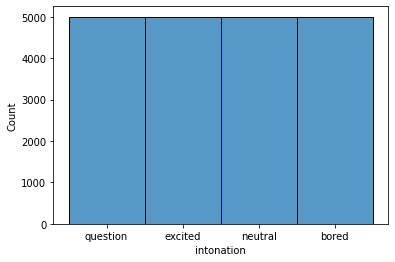

In [11]:
sns.histplot(labels['intonation'])

Again I have plotted a countplot of the intonations which again confirm a total 5000 for each intonation which are question, excited, neutral, bored.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


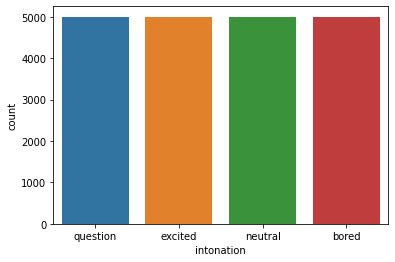

In [13]:
sns.countplot(labels['intonation'])

Here again I have used a countplot to plot the digit_label column wher we can see differnet counts for every integer.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


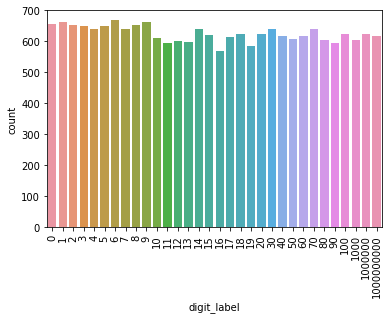

In [23]:
sns.countplot(labels['digit_label'])
plt.xticks(rotation="90")
plt.show()

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

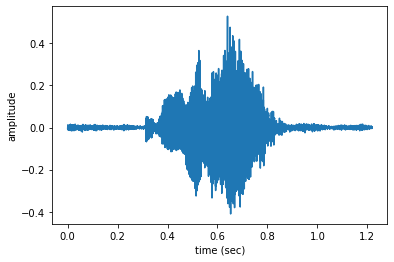

In [24]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

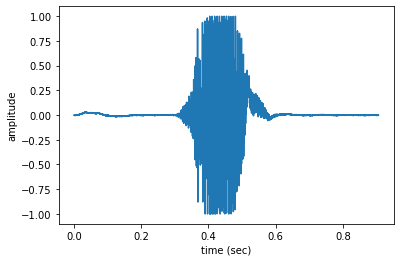

In [25]:
n=1
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

We can see here which file we are listening.

In [26]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0018596.wav'

In [27]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 26880 samples


Now we will try to extract few features from our signals and use these features instead as our predictors. In the following cell we will define a funciton that extracts four features of an audio signal which are :
1. Power
2. Pitch mean
3. Pitch standard deviation
4. Fraction of voiced region

In the below block of cell we define a function that gets pitch of an audio signal.

In [28]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

**Identifying a numeral in a short sequence.**

For that again we will use getXy file and here we will be suing fileID['digit_label'] to get the digit)label and would extract the same four featueres again 

In [334]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
      xi = [power,pitch_mean, pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

Here again I have kept the onlySingleDigit as False we are getting all the files and here we are using 500 files.

In [335]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=False)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


In [336]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (500, 4)
The shape of y is (500,)
The labels vector is [        12          1         40          9          6         80
         40         15          3         70         90          5
          5          5          2         70          9         60
         30         17         80         18         18         19
         13          0         40         50         11         60
         19         50         80         13          5          2
          4         19         19          7         17         13
         10          7          4         20         12        100
          4         70         20         20         11        100
       1000          6         11         17         11         18
          2         11    1000000          0         20          4
         20          3         10        100          4         11
          9         90          5         13    1000000          6
         10         10          6         40          0 

In [337]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


Again we are checking if for any NAN values.

In [338]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((350, 4), (150, 4), (350,), (150,))

In [ ]:
from sklearn.model_selection import GridSearchCV

**SVM**

Again we start with the SVM model.

In [345]:
model  = svm.SVC(C=2, gamma=0.001, kernel='rbf', class_weight='balanced')
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.21142857142857144
Validation  Accuracy 0.02


Here we are getting very low accuracies for our training and validation data.

In [346]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       0.29      0.17      0.21        12
           1       0.12      0.09      0.11        11
           2       0.33      0.38      0.35         8
           3       0.50      0.15      0.24        13
           4       0.08      0.22      0.12         9
           5       0.67      0.31      0.42        13
           6       0.13      0.58      0.22        12
           7       0.18      0.14      0.16        14
           8       0.20      0.40      0.27         5
           9       0.00      0.00      0.00        11
          10       0.33      0.60      0.43        10
          11       0.17      0.44      0.24         9
          12       1.00      0.10      0.18        10
          13       1.00      0.12      0.22        16
          14       0.00      0.00      0.00        10
          15       0.17      0.36      0.23        11
          16       0.38      0.30      0.33        10
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [347]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.17      0.25      0.20         8
           5       0.00      0.00      0.00         7
           6       0.05      0.33      0.08         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SVM on Normalised Data**

Trying SVM with normalised features.

In [350]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train_normalised = (X_train-mean)/sd
X_val_normalised  = (X_val-mean)/sd

In [351]:


model  = svm.SVC(C=1,gamma=1, kernel='rbf', class_weight='balanced'
                 )
model.fit(X_train_normalised,y_train)

yt_p = model.predict(X_train_normalised)
yv_p = model.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.49714285714285716
Validation  Accuracy 0.05333333333333334


Here we can see that our model is highly overfitting with training accuracy of 49.7% and 5 percnet for validation data.

In [352]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       0.75      0.25      0.38        12
           1       0.57      0.36      0.44        11
           2       0.50      0.62      0.56         8
           3       0.60      0.46      0.52        13
           4       0.38      0.33      0.35         9
           5       0.64      0.54      0.58        13
           6       0.38      0.83      0.53        12
           7       0.50      0.57      0.53        14
           8       0.29      0.80      0.42         5
           9       1.00      0.18      0.31        11
          10       0.44      0.70      0.54        10
          11       0.75      0.67      0.71         9
          12       0.78      0.70      0.74        10
          13       0.80      0.25      0.38        16
          14       0.50      0.50      0.50        10
          15       0.56      0.45      0.50        11
          16       0.83      0.50      0.62        10
          17       0.57    

In [353]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.25      0.12      0.17         8
           5       0.00      0.00      0.00         7
           6       0.12      0.67      0.20         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         6
          11       0.14      0.12      0.13         8
          12       0.00      0.00      0.00         4
          13       0.20      0.33      0.25         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**RandomForest**

Here we are using RandomForest and tuning the hyperparameters.

In [354]:
from sklearn.ensemble import RandomForestClassifier

In [355]:
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [356]:
grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train,y_train)

yt_p = grid_forest.predict(X_train)
yv_p = grid_forest.predict(X_val)


In [357]:
grid_forest.best_score_

0.06285714285714286

In [358]:
grid_forest.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 10,
 'n_estimators': 200}

In [359]:

clf_1 = RandomForestClassifier(max_depth=10,  criterion='gini', n_estimators=200, bootstrap=False, class_weight='balanced_subsample', 
                             n_jobs=-1)

In [360]:
clf_1.fit(X_train, y_train
        )

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [361]:
yt_p = clf_1.predict(X_train)
yv_p = clf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.9628571428571429
Validation  Accuracy 0.04


Here again our model is highly overfitting with validation accuracy only 4% and training accuracy 96%.

In [362]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00         8
           3       1.00      0.85      0.92        13
           4       1.00      0.89      0.94         9
           5       1.00      0.92      0.96        13
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00        11
          10       1.00      0.90      0.95        10
          11       1.00      0.89      0.94         9
          12       1.00      0.90      0.95        10
          13       1.00      0.94      0.97        16
          14       1.00      1.00      1.00        10
          15       0.85      1.00      0.92        11
          16       1.00      0.90      0.95        10
          17       1.00    

In [363]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         7
           6       0.17      0.33      0.22         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.14      0.17      0.15         6
          11       0.25      0.25      0.25         8
          12       0.00      0.00      0.00         4
          13       0.14      0.33      0.20         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.07    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**RandomForest on Normalised Data**

Again we try our model on normalised Data.

In [364]:
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [365]:
grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train_normalised,y_train)

yt_p = grid_forest.predict(X_train_normalised)
yv_p = grid_forest.predict(X_val_normalised)


In [366]:
grid_forest.best_score_

0.06285714285714286

In [367]:
grid_forest.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 10,
 'n_estimators': 200}

In [368]:

clf_1 = RandomForestClassifier(max_depth=10,  criterion='gini', n_estimators=200, bootstrap=False, class_weight='balanced_subsample', 
                             n_jobs=-1)



In [369]:
clf_1.fit(X_train_normalised, y_train
        )

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [370]:
yt_p = clf_1.predict(X_train_normalised)
yv_p = clf_1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.9657142857142857
Validation  Accuracy 0.04


After using normalised features also the model is still overfitting.

In [371]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         8
           3       1.00      0.92      0.96        13
           4       1.00      0.89      0.94         9
           5       1.00      0.92      0.96        13
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00        11
          10       1.00      0.90      0.95        10
          11       1.00      0.89      0.94         9
          12       1.00      0.90      0.95        10
          13       1.00      0.94      0.97        16
          14       1.00      1.00      1.00        10
          15       0.85      1.00      0.92        11
          16       1.00      0.90      0.95        10
          17       1.00    

In [372]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.17      0.12      0.14         8
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.20      0.17      0.18         6
          11       0.25      0.25      0.25         8
          12       0.00      0.00      0.00         4
          13       0.20      0.33      0.25         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.07    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**KNN**

In [373]:
parameters= {
    'n_neighbors': [50,60,70,80,90,100],
    
    'leaf_size': [1,2,3,4,5]
}

In [374]:
from sklearn.neighbors import KNeighborsClassifier
model_kn  = KNeighborsClassifier()

grid_kn = GridSearchCV(model_kn,parameters, n_jobs=-1)
grid_kn.fit(X_train,y_train)

yt_p = grid_kn.predict(X_train)
yv_p = grid_kn.predict(X_val)



In [375]:
grid_kn.best_params_

{'leaf_size': 1, 'n_neighbors': 100}

In [376]:
grid_kn.best_score_

0.03428571428571429

In [382]:
knn1 = KNeighborsClassifier(n_neighbors=100,leaf_size=1, n_jobs=-1)

knn1.fit(X_train,y_train)
yt_p = knn1.predict(X_train)
yv_p = knn1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.08
Validation  Accuracy 0.013333333333333334


Using KNN we are still getting very low accuracies with Training Accuracy of 8% and validation only 1%.

**KNN with different parameters**

In [383]:
parameters= {
    'n_neighbors': [50,60,70,80,90,100],
    'weights':['distance'],
    'leaf_size': [1,2,3,4,5]
}

In [384]:
from sklearn.neighbors import KNeighborsClassifier
model_kn  = KNeighborsClassifier()

grid_kn = GridSearchCV(model_kn,parameters, n_jobs=-1)
grid_kn.fit(X_train,y_train)

yt_p = grid_kn.predict(X_train)
yv_p = grid_kn.predict(X_val)



In [385]:
grid_kn.best_score_

0.05142857142857142

In [386]:
grid_kn.best_params_

{'leaf_size': 1, 'n_neighbors': 50, 'weights': 'distance'}

In [387]:
knn1 = KNeighborsClassifier(n_neighbors=50,leaf_size=1,weights='distance', n_jobs=-1)

knn1.fit(X_train,y_train)
yt_p = knn1.predict(X_train)
yv_p = knn1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.04


With normalised Data I the model is highly overfitting with Training Accuracy 100% and 4%.

**KNN with Normalised Data**

In [388]:
parameters= {
    'n_neighbors': [50,60,70,80,90,100],

    'leaf_size': [1,2,3,4,5]
}

In [389]:
model_kn_norm  = KNeighborsClassifier()

grid_kn_norm = GridSearchCV(model_kn_norm,parameters, n_jobs=-1)
grid_kn_norm.fit(X_train_normalised,y_train)



GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'leaf_size': [1, 2, 3, 4, 5],
                         'n_neighbors': [50, 60, 70, 80, 90, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [390]:
grid_kn_norm.best_score_

0.07142857142857142

In [391]:
grid_kn_norm.best_params_

{'leaf_size': 1, 'n_neighbors': 80}

In [392]:
knn1 = KNeighborsClassifier(n_neighbors=80,leaf_size=1 ,n_jobs=-1)


knn1.fit(X_train_normalised,y_train)
yt_p = knn1.predict(X_train_normalised)
yv_p = knn1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.10571428571428572
Validation  Accuracy 0.08


KNN with normalised features is giving us 8% and 10% for valdation and training accuracy.

In [393]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       0.09      0.17      0.12        12
           1       0.30      0.27      0.29        11
           2       0.00      0.00      0.00         8
           3       0.11      0.08      0.09        13
           4       0.00      0.00      0.00         9
           5       0.07      0.08      0.07        13
           6       0.13      0.67      0.22        12
           7       0.05      0.07      0.06        14
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00        10
          13       0.13      0.44      0.20        16
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00        10
          17       0.07    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [394]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.17      0.14      0.15         7
           2       0.00      0.00      0.00         2
           3       0.20      0.17      0.18         6
           4       0.17      0.12      0.14         8
           5       0.00      0.00      0.00         7
           6       0.11      1.00      0.19         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.20      0.17      0.18         6
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         4
          13       0.05      0.33      0.08         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Naive Bayes**

In [395]:
from sklearn.naive_bayes import GaussianNB

In [396]:
gnb = GaussianNB()

In [397]:
gnb.fit(X_train,y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.14857142857142858
Validation  Accuracy 0.07333333333333333


Using NaiveBayes we are getting validation accuracy of 7%  and Training Accuracy of 14%.

In [398]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       0.14      0.08      0.11        12
           1       0.11      0.18      0.13        11
           2       0.25      0.25      0.25         8
           3       0.00      0.00      0.00        13
           4       0.07      0.22      0.11         9
           5       0.50      0.08      0.13        13
           6       0.24      0.92      0.39        12
           7       0.00      0.00      0.00        14
           8       0.10      0.20      0.13         5
           9       0.00      0.00      0.00        11
          10       0.05      0.10      0.07        10
          11       0.36      0.44      0.40         9
          12       0.33      0.10      0.15        10
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        10
          15       0.17      0.09      0.12        11
          16       0.15      0.20      0.17        10
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [399]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.14      0.14      0.14         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.17      0.12      0.14         8
           5       0.00      0.00      0.00         7
           6       0.09      0.67      0.15         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.08      0.17      0.11         6
          11       0.33      0.38      0.35         8
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Naive Bayes on Normalised Data**

In [400]:
gnb.fit(X_train_normalised,y_train)

yt_p = gnb.predict(X_train_normalised)
yv_p = gnb.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.14285714285714285
Validation  Accuracy 0.07333333333333333




Naive Bayes using Normalised features we are getting 7% and 14% foir validation and training accuracy.



In [403]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       0.14      0.08      0.11        12
           1       0.11      0.18      0.13        11
           2       0.25      0.25      0.25         8
           3       0.00      0.00      0.00        13
           4       0.08      0.22      0.11         9
           5       0.50      0.08      0.13        13
           6       0.25      0.92      0.39        12
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        11
          10       0.06      0.10      0.07        10
          11       0.40      0.44      0.42         9
          12       0.33      0.10      0.15        10
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        10
          15       0.12      0.09      0.11        11
          16       0.14      0.20      0.17        10
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [404]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.14      0.14      0.14         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.17      0.12      0.14         8
           5       0.00      0.00      0.00         7
           6       0.09      0.67      0.15         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.08      0.17      0.11         6
          11       0.33      0.38      0.35         8
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Logistic Regression**

In [405]:
from sklearn.linear_model import LogisticRegression

In [406]:
parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,2,3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

In [407]:
lgr = LogisticRegression()

In [408]:
grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train,y_train)
yt_p = grid_lgr.predict(X_train)
yv_p = grid_lgr.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.04857142857142857
Validation  Accuracy 0.02


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [409]:
grid_lgr.best_score_

0.04285714285714286

In [410]:
grid_lgr.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'l1',
 'solver': 'saga'}

In [413]:
lgr = LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',  solver='saga', penalty='l1')
lgr.fit(X_train,y_train)
yt_p = lgr.predict(X_train)
yv_p = lgr.predict(X_val) 

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.04857142857142857
Validation  Accuracy 0.02


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Here again our model is overfitting with training accuracy of 4.8% and validation accuracy of 2%.

In [414]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00        10
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [415]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         7
           2       0.03      0.50      0.05         2
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.07      0.17      0.10         6
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Logistic Regression on Normalised Data**

In [416]:
parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,2,3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

In [417]:
lgr = LogisticRegression()

In [418]:
grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train_normalised,y_train)
yt_p = grid_lgr.predict(X_train_normalised)
yv_p = grid_lgr.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.13428571428571429
Validation  Accuracy 0.08666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [419]:
grid_lgr.best_score_

0.06285714285714286

In [420]:
grid_lgr.best_params_

{'C': 2,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'l1',
 'solver': 'saga'}

In [421]:
lgr = LogisticRegression(C=2, class_weight='balanced', multi_class='multinomial', penalty='l1', solver='saga')
lgr.fit(X_train_normalised,y_train)
yt_p = lgr.predict(X_train_normalised)
yv_p = lgr.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.13428571428571429
Validation  Accuracy 0.08666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [422]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.20      0.18      0.19        11
           2       0.18      0.38      0.24         8
           3       0.00      0.00      0.00        13
           4       0.11      0.11      0.11         9
           5       0.10      0.08      0.09        13
           6       0.36      0.75      0.49        12
           7       0.00      0.00      0.00        14
           8       0.10      0.60      0.18         5
           9       0.00      0.00      0.00        11
          10       0.12      0.10      0.11        10
          11       0.13      0.33      0.19         9
          12       0.12      0.20      0.15        10
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        11
          16       0.19      0.30      0.23        10
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [424]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.33      0.14      0.20         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         7
           6       0.22      0.67      0.33         3
           7       0.00      0.00      0.00         4
           8       0.08      0.50      0.13         2
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         6
          11       0.36      0.50      0.42         8
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         2
          16       0.11      0.25      0.15         4
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Multilayer Perceptron**

In [425]:
parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [300,400,500],
    'random_state': [1,2,3]
    
}

In [426]:
clf_grid = MLPClassifier()

In [427]:
grid_mlp = GridSearchCV(clf_grid, parameters, n_jobs=-1)
grid_mlp.fit(X_train_normalised,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [429]:
grid_mlp.best_params_

{'activation': 'tanh', 'max_iter': 300, 'random_state': 3, 'solver': 'sgd'}

In [430]:
grid_mlp.best_score_

0.09428571428571428

In [431]:
clf = MLPClassifier(max_iter=300, solver='sgd', activation='tanh',random_state=3).fit(X_train_normalised, y_train)
yt_p = clf.predict(X_train_normalised)
yv_p = clf.predict(X_val_normalised)



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [432]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.12
Validation  Accuracy 0.08


In [433]:
parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [300,400,500],
    'random_state': [1,2,3]
    
}

In [434]:
clf_grid = MLPClassifier()

In [436]:
grid_mlp = GridSearchCV(clf_grid, parameters, n_jobs=-1)
grid_mlp.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [437]:
grid_mlp.best_score_

0.06857142857142857

In [438]:
grid_mlp.best_params_

{'activation': 'logistic', 'max_iter': 500, 'random_state': 2, 'solver': 'sgd'}

In [439]:
clf = MLPClassifier(max_iter=500, solver='sgd', activation='logistic',random_state=2).fit(X_train_normalised, y_train)
yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)



In [440]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.04285714285714286
Validation  Accuracy 0.03333333333333333


**Advance Solution with Extra Features**

In [ ]:
Here again I am trying to extract more features, again I am using getXy function to get the files with desried features.

Here I am using an extra feature which is mfcc

In [450]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
      mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))

      xi = [power,pitch_mean, pitch_std,voiced_fr, mfccs]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

In [451]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=False)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 500/500 [02:52<00:00,  2.90it/s]


In [452]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (500, 5)
The shape of y is (500,)
The labels vector is [        12          1         40          9          6         80
         40         15          3         70         90          5
          5          5          2         70          9         60
         30         17         80         18         18         19
         13          0         40         50         11         60
         19         50         80         13          5          2
          4         19         19          7         17         13
         10          7          4         20         12        100
          4         70         20         20         11        100
       1000          6         11         17         11         18
          2         11    1000000          0         20          4
         20          3         10        100          4         11
          9         90          5         13    1000000          6
         10         10          6         40          0 

Here I am usig MinMAx Scaler to scale our featuresan use it for our modeling.

In [453]:
from sklearn.preprocessing import MinMaxScaler

In [454]:
scaler = MinMaxScaler()

In [455]:
print(scaler.fit(X))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [456]:
print(scaler.transform(X))

[[0.14634564 0.50969173 0.21648964 0.40155552 0.42145494]
 [0.3443301  0.42027734 0.41800351 0.30225143 0.53596446]
 [0.38003924 0.28838555 0.13964339 0.32593645 0.70875171]
 ...
 [0.32296866 0.46463987 0.51797776 0.37201018 0.2488368 ]
 [0.06508069 0.72490364 0.55129654 0.45210539 0.        ]
 [0.31409357 0.53508526 0.16079698 0.16835156 0.31328557]]


In [457]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((350, 5), (150, 5), (350,), (150,))

In [449]:

mean = X_train.mean(0)
sd =  X_train.std(0)

X_train_normalised = (X_train-mean)/sd
X_val_normalised  = (X_val-mean)/sd


SVM using MinMAX scaled Features

In [458]:
model  = svm.SVC()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.06285714285714286
Validation  Accuracy 0.02666666666666667


Here we can see our model is underfitting with very low accuracies on our training as well as on our validation data on default parameters.

In [460]:
model  = svm.SVC(C=1, gamma=1, kernel='rbf', class_weight='balanced')
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.9971428571428571
Validation  Accuracy 0.02666666666666667


After tuning the parameters our model is highly overfitting with trianing accuracy of 99% and validation accuracy of only 2%.

**SVM on Normalised Data**

In [125]:

model  = svm.SVC()
model.fit(X_train_normalised,y_train)

yt_p = model.predict(X_train_normalised)
yv_p = model.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))


Training Accuracy 0.22285714285714286
Validation  Accuracy 0.04


In [35]:

model  = svm.SVC(C=2, gamma=2, kernel='rbf', class_weight='balanced')
model.fit(X_train_normalised,y_train)

yt_p = model.predict(X_train_normalised)
yv_p = model.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))


Training Accuracy 0.9485714285714286
Validation  Accuracy 0.02666666666666667


Trying on the normalised also gave us poor accuracies.

RandomForest Classifier using MinMAX scaled Features

In [461]:
from sklearn.model_selection import GridSearchCV

In [462]:
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [463]:
from sklearn.ensemble import RandomForestClassifier

In [464]:
grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train,y_train)

#yt_p = grid_forest.predict(X_train)
#yv_p = grid_forest.predict(X_val)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [465]:
grid_forest.best_score_

0.06285714285714286

In [466]:
grid_forest.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'n_estimators': 200}

In [467]:

clf_1 = RandomForestClassifier(max_depth=10,  criterion='gini', n_estimators=200, bootstrap=False, class_weight='balanced_subsample', 
                             n_jobs=-1)


clf_1.fit(X_train, y_train)
yt_p = clf_1.predict(X_train)
yv_p = clf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.9942857142857143
Validation  Accuracy 0.03333333333333333


Random Forest model is also overfitting with training accuracy of 99% and validation of 3%

**RandomForest on Normalised Data**

In [60]:
      
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}


In [61]:

grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train_normalised,y_train)

yt_p = grid_forest.predict(X_train_normalised)
yv_p = grid_forest.predict(X_val_normalised)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [62]:
grid_forest.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'n_estimators': 300}

In [63]:
grid_forest.best_score_

0.06571428571428573

In [66]:

clf_1 = RandomForestClassifier(max_depth=9,  criterion='gini', n_estimators=300, bootstrap=False, class_weight='balanced', 
                             n_jobs=-1)


clf_1.fit(X_train_normalised, y_train)
yt_p = clf_1.predict(X_train_normalised)
yv_p = clf_1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))'''

Training Accuracy 0.9657142857142857
Validation  Accuracy 0.02666666666666667


**KNN**

In [468]:
parameters= {
    'n_neighbors': [50,60,70,80,90,100],
    'weights':['distance'],
    'leaf_size': [1,2,3,4,5]
}

In [469]:
from sklearn.neighbors import KNeighborsClassifier
model_kn  = KNeighborsClassifier()

grid_kn = GridSearchCV(model_kn,parameters, n_jobs=-1)
grid_kn.fit(X_train,y_train)

yt_p = grid_kn.predict(X_train)
yv_p = grid_kn.predict(X_val)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [470]:
grid_kn.best_params_

{'leaf_size': 1, 'n_neighbors': 100, 'weights': 'distance'}

In [471]:
grid_kn.best_score_

0.05142857142857142

In [474]:
knn1 = KNeighborsClassifier(n_neighbors=100,leaf_size=1,weights='distance', n_jobs=-1)

knn1.fit(X_train,y_train)
yt_p = knn1.predict(X_train)
yv_p = knn1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.02


**KNN with different distance metric**

In [475]:
knn1 = KNeighborsClassifier(n_neighbors=60,leaf_size=1, n_jobs=-1)

knn1.fit(X_train,y_train)
yt_p = knn1.predict(X_train)
yv_p = knn1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.08571428571428572
Validation  Accuracy 0.03333333333333333


**KNN on Normalised Data**

In [89]:

parameters= {
    'n_neighbors': [50,60,70,80,90,100],
    'weights':['distance'],
    'leaf_size': [1,2,3,4,5]
}

In [90]:

from sklearn.neighbors import KNeighborsClassifier
model_kn  = KNeighborsClassifier()

grid_kn = GridSearchCV(model_kn,parameters, n_jobs=-1)
grid_kn.fit(X_train_normalised,y_train)

yt_p = grid_kn.predict(X_train_normalised)
yv_p = grid_kn.predict(X_val_normalised)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [91]:
grid_kn.best_score_

0.05142857142857142

In [92]:
grid_kn.best_params_

{'leaf_size': 1, 'n_neighbors': 50, 'weights': 'distance'}

In [94]:

knn1 = KNeighborsClassifier(n_neighbors=50,leaf_size=1,weights='distance', n_jobs=-1)

knn1.fit(X_train_normalised,y_train)
yt_p = knn1.predict(X_train_normalised)
yv_p = knn1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))'''

Training Accuracy 0.10857142857142857
Validation  Accuracy 0.04666666666666667


**KNN on Normalised Data with different Distance metric**

In [95]:

knn1 = KNeighborsClassifier(n_neighbors=50,leaf_size=1, n_jobs=-1)

knn1.fit(X_train_normalised,y_train)
yt_p = knn1.predict(X_train_normalised)
yv_p = knn1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))


Training Accuracy 0.10857142857142857
Validation  Accuracy 0.04666666666666667


**Naive Bayes**

In [476]:
from sklearn.naive_bayes import GaussianNB

In [477]:
gnb = GaussianNB()

In [478]:
gnb.fit(X_train,y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.1657142857142857
Validation  Accuracy 0.08


**Naive Bayes on Normalised Data**

In [99]:
gnb = GaussianNB()

In [100]:

gnb.fit(X_train_normalised,y_train)

yt_p = gnb.predict(X_train_normalised)
yv_p = gnb.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.17714285714285713
Validation  Accuracy 0.02


**Logistic Regression**

In [479]:
from sklearn.linear_model import LogisticRegression

In [480]:
parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,2,3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

In [481]:
lgr = LogisticRegression()

In [482]:
grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train,y_train)
yt_p = grid_lgr.predict(X_train)
yv_p = grid_lgr.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training Accuracy 0.045714285714285714
Validation  Accuracy 0.02


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [483]:
grid_lgr.best_score_

0.02

In [484]:
grid_lgr.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'none',
 'solver': 'sag'}

In [485]:
lgr = LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',  solver='sag')
lgr.fit(X_train,y_train)
yt_p = lgr.predict(X_train)
yv_p = lgr.predict(X_val) 

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.045714285714285714
Validation  Accuracy 0.02


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Logistic Regression on the Normalised Data**

In [116]:

parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,0.2,0.3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

In [117]:
lgr = LogisticRegression()

In [118]:

grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train_normalised,y_train)
yt_p = grid_lgr.predict(X_train_normalised)
yv_p = grid_lgr.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.09428571428571429
Validation  Accuracy 0.03333333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [119]:
grid_lgr.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'none',
 'solver': 'sag'}

In [120]:
grid_lgr.best_score_

0.03428571428571429

In [121]:

lgr = LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',  solver='saga')
lgr.fit(X_train_normalised,y_train)
yt_p = lgr.predict(X_train_normalised)
yv_p = lgr.predict(X_val_normalised) 

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.09714285714285714
Validation  Accuracy 0.02


In [486]:
from sklearn.neural_network import MLPClassifier

In [487]:
mlp_1 = MLPClassifier()

In [488]:
parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [200,300],
    
}

In [492]:
grid_mlp = GridSearchCV(mlp_1, parameters, n_jobs=-1)
grid_mlp.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [493]:
grid_mlp.best_score_

0.054285714285714284

In [494]:
grid_mlp.best_params_

{'activation': 'logistic', 'max_iter': 200, 'solver': 'sgd'}

In [495]:
clf = MLPClassifier(activation='logistic', max_iter=200, solver='sgd').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [496]:
yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.07714285714285714
Validation  Accuracy 0.04


Achieving very low accuracies in every model after trying different normalisations and different features.

**ADVANCE SOLUTION (Different Problem Statement)**

As we can conclude form the above model that we were getting very poor results for predicting the digit_label.

So I tried with a different problem with a unique approach, trying to predict the digit_label of only single digits, and extracting all the 20k files and modeling on it.

Here I am again using the getXy function ot get the files but here I am using 10 features.

In [520]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      #Extra Features 

      onset = np.mean(librosa.onset.onset_detect(x,fs))
      mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))
      zcr = np.mean(librosa.feature.zero_crossing_rate(x))
      spc = np.mean(librosa.feature.spectral_centroid(x, fs))
      spr = np.mean(librosa.feature.spectral_rolloff(x, fs))
      rms = np.mean(librosa.feature.rms(x, fs))
      
      #mf1 = np.mean(mfccs)

      xi = [power,pitch_mean,pitch_std,voiced_fr,onset,mfccs,zcr,spc,spr,rms]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

In [521]:
X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 20000/20000 [54:45<00:00,  6.09it/s]


Here I got all the 20k files with single digits.

In [522]:
from numpy import asarray
from numpy import save

# save to npy file
save('/content/drive/MyDrive/Data/MLEnd/X.npy', X)
save('/content/drive/MyDrive/Data/MLEnd/y.npy', y)

As it took around an hour to load all the files i stored them in the drive.

In [3]:
from numpy import load
X = load('/content/drive/MyDrive/Data/MLEnd/X.npy')
y = load('/content/drive/MyDrive/Data/MLEnd/y.npy')

Here I am converting our features into a dataframe which will help us in visualisations.

In [4]:
data_a = np.column_stack((X,y))
df_a= pd.DataFrame(data_a,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms','y'])

Here is a pie chart of all the single digit labels.

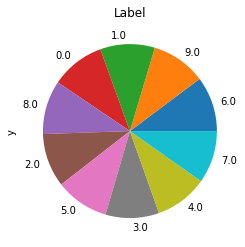

In [5]:
df_a['y'].value_counts().plot(kind='pie')
plt.title('Label')
plt.grid()
plt.show()

Here is a correlation matrix of all the features.

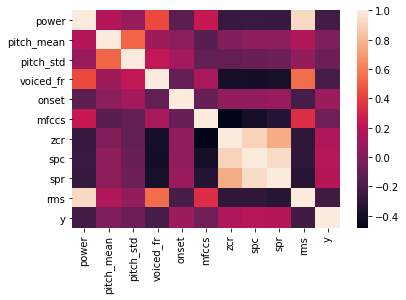

In [8]:
corrMa = df_a.corr()
sns.heatmap(corrMa)

Here I plotted a pairplot using seborn.

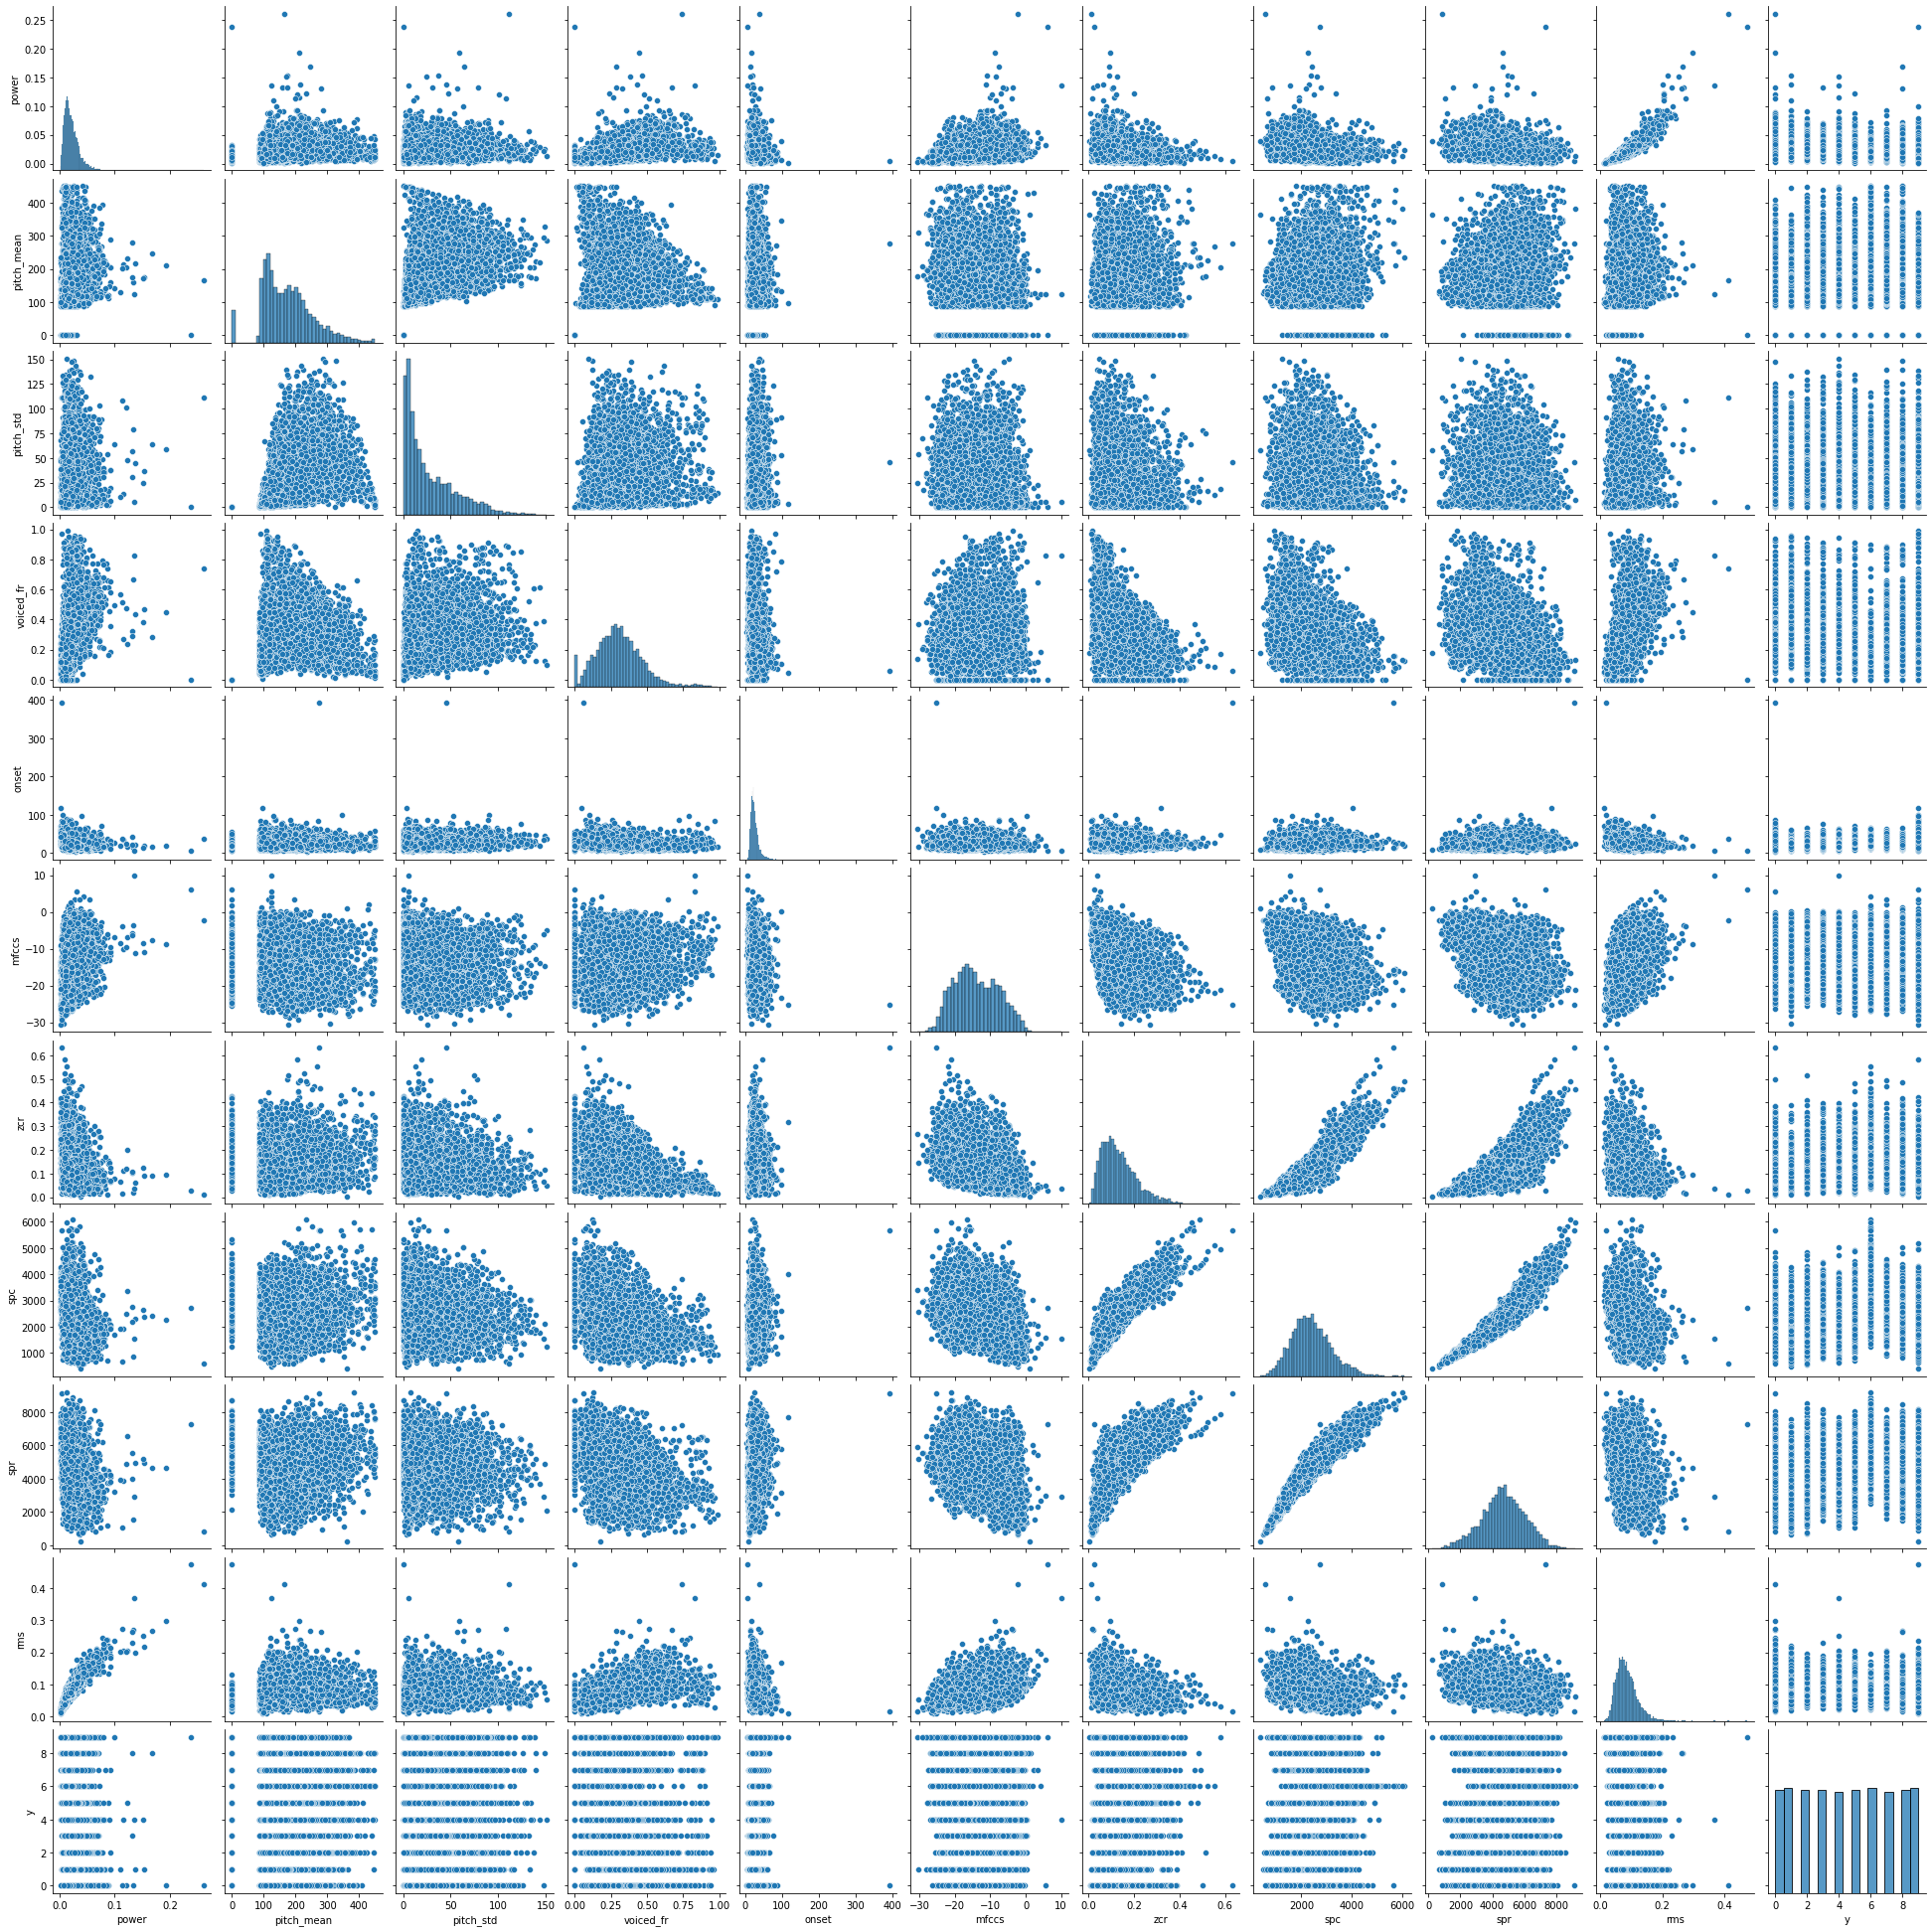

In [9]:
sns.pairplot(df_a)

In [10]:
dfx = pd.DataFrame(X,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms'])


Here again using Standard Scaler to scale the features.

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dfx_r = scaler.fit_transform(dfx)

In [12]:
dfx_rr = pd.DataFrame(dfx_r,columns=['power','pitch_mean','pitch_std','voiced_fr','onset','mfccs','zcr','spc','spr','rms'])

In [13]:
X = dfx_rr.to_numpy()

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4573, 10), (1960, 10), (4573,), (1960,))

In [17]:
from keras.constraints import max_norm

Now using Keras Sequential API to build Neural Network

In [19]:
from keras import Sequential

In [20]:
from keras.layers import Activation, Dense, Dropout
from keras.constraints import max_norm
model = Sequential()

model.add(Dense(256, activation='relu', input_shape= (X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

Here i have used Dense Layer and a Dropout Layer after each layer to stop overfitting.

In [24]:
e =100
histroy = model.fit(   X_train,
    y_train,
    batch_size=16,
    epochs=e,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),)

Epoch 1/100
286/286 [==============================] - 1s 3ms/step - loss: 1.7313 - accuracy: 0.3829 - val_loss: 1.7966 - val_accuracy: 0.3561
Epoch 2/100
286/286 [==============================] - 1s 3ms/step - loss: 1.7539 - accuracy: 0.3735 - val_loss: 1.7951 - val_accuracy: 0.3571
Epoch 3/100
286/286 [==============================] - 1s 3ms/step - loss: 1.7495 - accuracy: 0.3831 - val_loss: 1.7931 - val_accuracy: 0.3628
Epoch 4/100
286/286 [==============================] - 1s 2ms/step - loss: 1.7604 - accuracy: 0.3794 - val_loss: 1.7904 - val_accuracy: 0.3587
Epoch 5/100
286/286 [==============================] - 1s 2ms/step - loss: 1.7309 - accuracy: 0.3868 - val_loss: 1.7894 - val_accuracy: 0.3633
Epoch 6/100
286/286 [==============================] - 1s 2ms/step - loss: 1.7512 - accuracy: 0.3781 - val_loss: 1.8009 - val_accuracy: 0.3561
Epoch 7/100
286/286 [==============================] - 1s 3ms/step - loss: 1.7556 - accuracy: 0.3838 - val_loss: 1.7962 - val_accuracy: 0.3485

Getting 40% accuracy on the training accuracy and 35.5% for validation data.

In [25]:
model.evaluate(X_val, y_val)

62/62 [==============================] - 0s 1ms/step - loss: 1.8008 - accuracy: 0.3556


[1.8008089065551758, 0.35561224818229675]

Visulaisation on the model accuracy and model loss throughout the epochs.

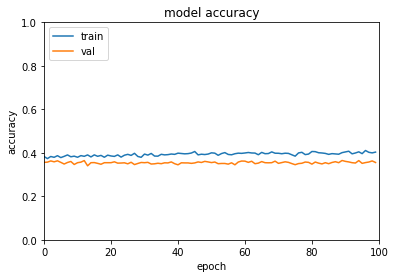

In [29]:
plt.plot(histroy.history['accuracy'])
plt.plot(histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.axis([0,e,0,1])
plt.show()

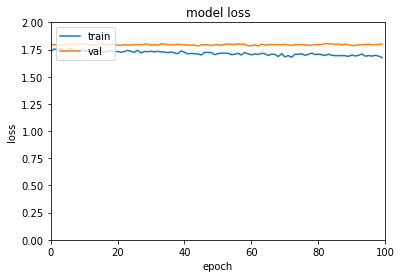

In [30]:
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.axis([0,e,0,2])
plt.show()

**Brief Summary of Advance Solution**

*1)*
I started the advance solution with the problem statement of predicting the digit_label and i tried all the 6 models again on the data, with hyperparameter tuning of the models and also using MinMax scaler and also adding more featueres in, but all the models were performing very poorly.

*2)*
In the second problem statement I chose to predict the digit_label fo only single digits and taking all the 20000 files and using Keras Sequential API to build the neural netwrok giving us the accuracy of 35% in the validation data.